In [1]:
!pip install tensorflow_addons
!pip install deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400 kB 4.5 MB/s 
     |████████████████████████████████| 132 kB 12.5 MB/s 
     |████████████████████████████████| 79 kB 4.0 MB/s 
     |████████████████████████████████| 6.7 MB 7.3 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 10.3 MB 46.2 MB/s 
     |████████████████████████████████| 140 kB 15.8 MB/s 
     |████████████████████████████████| 132 kB 51.3 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 127 kB 6.0 MB/s 
  Created wheel for deeplake: filename=deeplake-3.1.4-py3-none-any.whl size=484622 sha256=19d82a654caddce6663b27b97c0c59d4e38bedc2b591bc392069fe00af36177a
  Stored in direct

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import deeplake

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 
time: 610 µs (started: 2022-12-20 09:25:44 +00:00)


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
time: 1.73 s (started: 2022-12-20 09:25:44 +00:00)


In [29]:
ds_train = deeplake.load("hub://activeloop/tiny-imagenet-train")
ds_test = deeplake.load("hub://activeloop/tiny-imagenet-test")
ds_train = ds_train.tensorflow()
ds_test = ds_test.tensorflow()

print(type(ds_train))

'''
print(ds_train.tensors.keys())
print(ds_train.labels[0].numpy())
print(ds_train.images[0][2])
'''
'''
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
'''

hub://activeloop/tiny-imagenet-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-train
hub://activeloop/tiny-imagenet-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/tiny-imagenet-test
<class 'deeplake.core.dataset.deeplake_cloud_dataset.DeepLakeCloudDataset'>
dict_keys(['boxes', 'images', 'labels'])
[21692]
Tensor(key='images', index=Index([0, 2]))


'\n\ndef normalize_img(image, label):\n  """Normalizes images: `uint8` -> `float32`."""\n  return tf.cast(image, tf.float32) / 255., label\n\nds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)\nds_train = ds_train.cache()\nds_train = ds_train.shuffle(ds_info.splits[\'train\'].num_examples)\nds_train = ds_train.batch(128)\nds_train = ds_train.prefetch(tf.data.AUTOTUNE)\n\nds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)\nds_test = ds_test.batch(128)\nds_test = ds_test.cache()\nds_test = ds_test.prefetch(tf.data.AUTOTUNE)\n'

time: 1.5 s (started: 2022-12-20 09:46:50 +00:00)


In [ ]:
def get_adversial_exemple(model, dataset, eps):
  adversarial_examples = []
  for images, labels in dataset:
    with tf.GradientTape() as tape:
      tape.watch(images)
      predictions = model(images)
      loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adversarial_example = images + eps * signed_grad
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)
    adversarial_examples.append(adversarial_example)
  adversarial_examples = np.concatenate(adversarial_examples,axis=0)
  return adversarial_examples


time: 3.21 ms (started: 2022-12-19 10:02:27 +00:00)


In [ ]:
# Shallow softmax model

shallow_softmax = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_softmax.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_softmax.fit(ds_train, epochs=5)
shallow_softmax.evaluate(ds_test)


ValueError: ignored

time: 262 ms (started: 2022-12-19 10:02:34 +00:00)


In [ ]:
# Shallow maxout model inspired from https://github.com/philipperemy/tensorflow-maxout/blob/master/mnist_maxout_example.py

shallow_maxout = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(100),
  tfa.layers.Maxout(50),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation='softmax'),
])

shallow_maxout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

shallow_maxout.fit(ds_train, epochs=5)
shallow_maxout.evaluate(ds_test) 


Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.4128 - accuracy: 0.8826
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1467 - accuracy: 0.9579
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1055 - accuracy: 0.9689
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0836 - accuracy: 0.9754
Epoch 5/5
79/79 [==============================] - 0s 2ms/step - loss: 0.0926 - accuracy: 0.9733


[0.09262516349554062, 0.9732999801635742]

time: 12.9 s (started: 2022-12-19 08:25:51 +00:00)


In [ ]:
# convert tf.data.Dataset to numpy array
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)


time: 90 ms (started: 2022-12-19 08:26:04 +00:00)


In [ ]:
# avaluate shallow_softmax model on adversarial examples
x_test_adv = get_adversial_exemple(shallow_softmax, ds_test, eps=0.25)
loss, accuracy =  shallow_softmax.evaluate(x_test_adv, y_test)
confidence = np.mean(np.max(shallow_softmax.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )


313/313 [==============================] - 1s 1ms/step
Accuracy on adversarial examples: 0.0 with a mean confidence of 0.8789599537849426
time: 1.85 s (started: 2022-12-19 08:26:04 +00:00)


In [ ]:
# evaluate shallow_maxout model on adversarial examples
x_test_adv = get_adversial_exemple(shallow_maxout, ds_test, eps=0.25)
loss, accuracy =  shallow_maxout.evaluate(x_test_adv, y_test)
confidence = np.mean(np.max(shallow_maxout.predict(x_test_adv), axis=1))
print(f"Accuracy on adversarial examples: {accuracy} with a mean confidence of {confidence}", )


313/313 [==============================] - 1s 2ms/step
Accuracy on adversarial examples: 0.0035000001080334187 with a mean confidence of 0.9171356558799744
time: 2.23 s (started: 2022-12-19 08:26:06 +00:00)


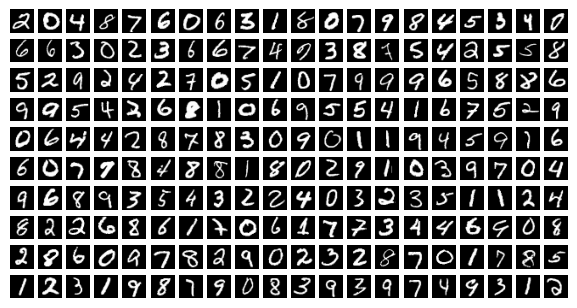

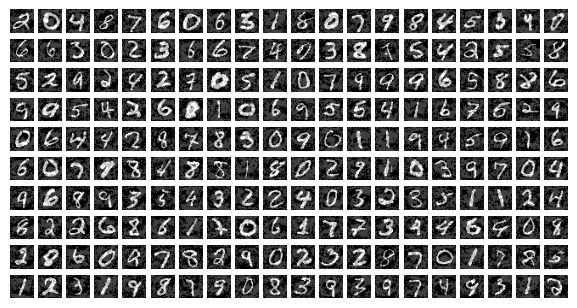

time: 14.7 s (started: 2022-12-19 08:27:33 +00:00)


In [ ]:
#Afficher les images
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
plt.figure(1)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.figure(figsize=(7.195, 3.841), dpi=100)
plt.figure(2)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(x_test_adv[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')

plt.show()
